In [2]:
import sys
sys.path.append('../')
from abel.utilities.larmor import larmor_formula, mean_larmor_formula
from abel import *
import scipy.constants as SI


%load_ext autoreload
%autoreload 2

In [7]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 50e-6 # [m]
driver.z_offset = 580e-6 # [m]
driver.emit_nx, driver.emit_ny = 80e-6, 80e-6 # [m rad]
driver.beta_x, driver.beta_y = 5, 5 #30e-3, 30e-3 [m]
driver.num_particles = 100000
driver.jitter.x = 2e-7 # [m] 2e-6
driver.jitter.y = 2e-7 # [m] 100e-9
driver.jitter.t = 0 #10e-15 # [m]
driver.symmetrize = True

test_particle = SourceSingleParticle()
test_particle.energy = 1500e9 # [eV]
test_particle.z = 0 # [m]
test_particle.x = 0 # [m]
test_particle.y = 0 # [m]
test_particle.yp = 0
test_particle.xp = 0

# define stage
stage = StageHipace()
stage.plasma_density = 2e21 # [m^-3]
stage.driver_source = driver
stage.test_particle_source = test_particle

gamma = test_particle.energy * e /SI.m_e/SI.c**2
kp = np.sqrt(stage.plasma_density*SI.e**2/SI.m_e/SI.epsilon_0)/SI.c
beta_matched = np.sqrt(2*gamma)/kp # Vector
lambda_beta = 2*np.pi*beta_matched
stage.length = 2*lambda_beta # [m]

stage.nom_energy_gain = 31.9e9/(11/stage.length) # [eV]
stage.radiation_reaction = False
stage.ion_motion = False
stage.beam_ionization=False
stage.ramp_beta_mag = 5
stage.num_nodes = 16

# define first stage (half length)
#first_stage = StageHipace()
#first_stage.driver_source = driver
#first_stage.length = stage.length/2 # [m]
#first_stage.plasma_density = 2e21 # [m^-3]
#first_stage.nom_energy_gain = stage.nom_energy_gain/2 # [eV]
#first_stage.radiation_reaction = stage.radiation_reaction

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = test_particle.energy # [eV]
source.rel_energy_spread = 0.01
source.bunch_length = 28e-6 # [m]
source.z_offset = 0e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
source.num_particles = 50000
source.jitter.t = driver.jitter.t

# define interstage
interstage = InterstageBasic()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 1 # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
#linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 1

save = False
shots = 10

# Without Radiation Reaction

In [8]:
name = f'linac_hipace_test_particle_{int(source.energy/1e9)}GeV_\
{interstage.dipole_field}T_ex_{source.emit_nx*1e6}_jitterx_{driver.jitter.x}_\
jittery_{driver.jitter.y}_RR_{stage.radiation_reaction}N_{linac.num_stages}_11m_{shots}_shot\
_{source.num_particles}_particles\
inits_z{test_particle.z*1e6}_x{test_particle.x*1e6}_y{test_particle.y*1e6}\
_xp{test_particle.xp*1e6}_yp{test_particle.z*1e6}'

linac.run(name, num_shots=shots, overwrite=False, parallel=False);

>> SHOT 1/10
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1499.9 GeV, -1.60 nC, 1.0% rms, 160.7/0.6 µm-rad)
Running job 5821429
>> Starting (0:00)
>> Running (0:10)
>> Running (0:20)
>> Running (0:30)
>> Running (0:40)
>> Running (0:50)
>> Ending (0:59)
Tracking element 2 (StageHipace, stage 1, s = 3.6 m, 1511.1 GeV, -1.60 nC, 1.0% rms, 160.8/0.6 µm-rad)
>> SHOT 2/10
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.0 GeV, -1.60 nC, 1.0% rms, 159.6/0.6 µm-rad)
Running job 5821438
>> Starting (0:00)
>> Running (0:10)
>> Running (0:20)
>> Running (0:30)
>> Running (0:40)
>> Running (0:51)
>> Ending (0:57)
Tracking element 2 (StageHipace, stage 1, s = 3.6 m, 1511.2 GeV, -1.60 nC, 1.0% rms, 159.6/0.6 µm-rad)
>> SHOT 3/10
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.1 GeV, -1.60 nC, 1.0% rms, 159.9/0.6 µm-rad)
Running job 5821446
>> Starting (0:00)
>> Running (0:07)
>> Running (0:17)
>> Running (0:27)
>> Running (0:37)
>> Running (0:47)
>> Running (0:57)
>> Endi

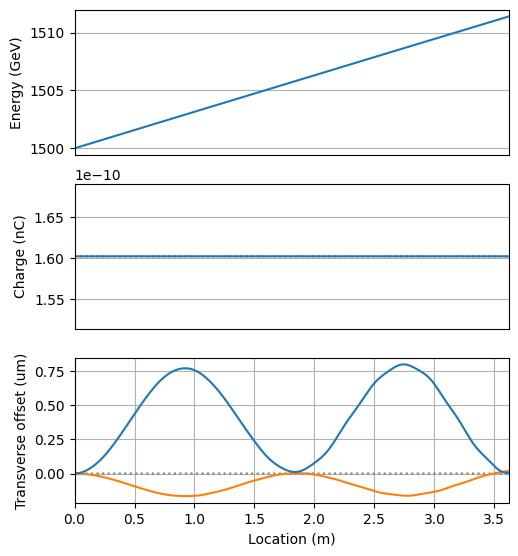

In [9]:
stage_evolution = linac.stages[0].plot_test_particle_evolution()

In [10]:
Es = linac.stages[0].test_particle_evolution.energy

In [11]:
if save:
    stage_evolution.savefig(f'Plots_with_updated_params/Hipace_test_particle_stage_evolution_\
    {shots}_shots_{int(source.energy/1e9)}GeV_{int(source.emit_nx*1e6)}\
    mmmrad_{int(source.emit_ny*1e6)}\
    mmmrad_{interstage.dipole_field}T_RR_{stage.radiation_reaction}_\
    B_{interstage.dipole_field}T_11m_{source.num_particles}_particles\
    inits_z{test_particle.z*1e6}_x{test_particle.x*1e6}_y{test_particle.y*1e6}\
    _xp{test_particle.xp*1e6}_yp{test_particle.z*1e6}.png')

# With Radiation Reaction

In [12]:
stage.radiation_reaction = True
linac2 = Linac()
linac2.source = source
linac2.stage = stage
#lina2c.first_stage = first_stage
linac2.interstage = interstage
linac2.num_stages = 1

In [13]:
name = f'linac_hipace_test_particle_{int(source.energy/1e9)}GeV_\
{interstage.dipole_field}T_ex_{source.emit_nx*1e6}_jitterx_{driver.jitter.x}_\
jittery_{driver.jitter.y}_RR_{stage.radiation_reaction}N_{linac.num_stages}_11m_{shots}_shot\
_{source.num_particles}_particles\
inits_z{test_particle.z*1e6}_x{test_particle.x*1e6}_y{test_particle.y*1e6}\
_xp{test_particle.xp*1e6}_yp{test_particle.z*1e6}'

linac2.run(name, num_shots=shots, overwrite=False, parallel=False);

>> SHOT 1/10
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.0 GeV, -1.60 nC, 1.0% rms, 161.0/0.6 µm-rad)
Running job 5821907
>> Running (0:00)
>> Running (0:10)
>> Running (0:20)
>> Running (0:30)
>> Running (0:40)
>> Running (0:51)
>> Ending (0:56)
Tracking element 2 (StageHipace, stage 1, s = 3.6 m, 1510.6 GeV, -1.60 nC, 1.0% rms, 161.1/0.6 µm-rad)
>> SHOT 2/10
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.0 GeV, -1.60 nC, 1.0% rms, 159.9/0.6 µm-rad)
Running job 5821921
>> Running (0:00)
>> Running (0:10)
>> Running (0:20)
>> Running (0:30)
>> Running (0:41)
>> Running (0:51)
>> Running (1:01)
>> Ending (1:02)
Tracking element 2 (StageHipace, stage 1, s = 3.6 m, 1510.6 GeV, -1.60 nC, 1.0% rms, 159.9/0.6 µm-rad)
>> SHOT 3/10
Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 1500.1 GeV, -1.60 nC, 1.0% rms, 161.9/0.6 µm-rad)
Running job 5822118
>> Starting (0:00)
>> Running (0:07)
>> Running (0:17)
>> Running (0:27)
>> Running (0:37)
>> Running (0:47)
>> Runnin

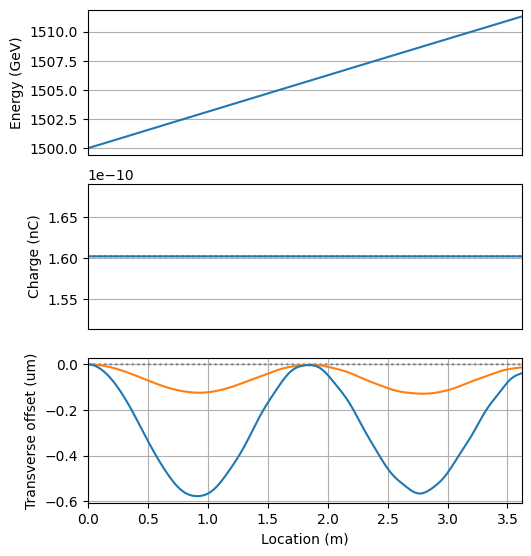

In [14]:
stage_evolution = linac2.stages[0].plot_test_particle_evolution()

# Comparing the 2

In [15]:
s = linac2.stages[0].test_particle_evolution.location
xp = linac2.stages[0].test_particle_evolution.xp
yp = linac2.stages[0].test_particle_evolution.yp
Es2 = linac2.stages[0].test_particle_evolution.energy
gammas = Es2*SI.e/SI.m_e/SI.c**2


if Es.size > Es2.size:
    Es = np.array([Es[i] for i in range(Es2.size)])
elif Es2.size > Es.size:
    Es2 = np.array([Es2[i] for i in range(Es.size)])


z, P = larmor_formula(s, xp, yp, gammas)
P = P / SI.e /1e9
E_loss = Es - Es2
P_real = [1/1e9 * (E_loss[i+1] - E_loss[i])/(s[1]-s[0]) for i in range(E_loss.size-1)]

Text(0.5, 1.0, 'Radiated power due to radiation reactionfor an initial energy of 1500.0 GeV')

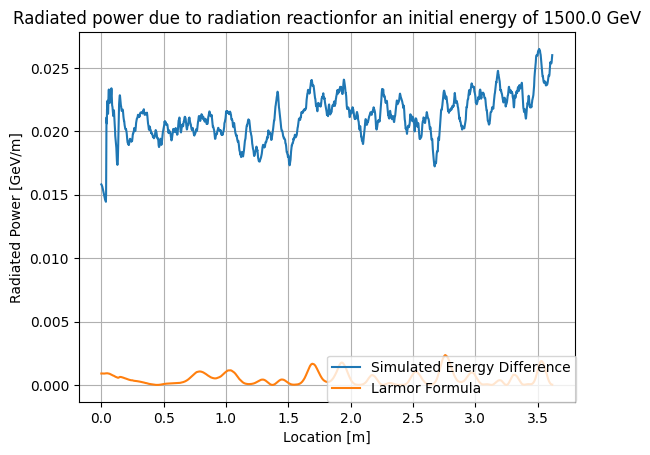

In [16]:
fig = plt.figure()
plt.plot(z, P_real, label = 'Simulated Energy Difference')
plt.plot(z, P, label = 'Larmor Formula')
plt.grid()
plt.xlabel('Location [m]')
plt.ylabel('Radiated Power [GeV/m]')
plt.legend(loc = (0.5,0))
plt.title(f'Radiated power due to radiation reaction\
for an initial energy of {test_particle.energy/1e9} GeV')


In [17]:
#if save:
#fig.savefig(f'Plots_with_updated_params/Hipace_test_particle_Radiated_Power_\
#{shots}_shots_{int(source.energy/1e9)}GeV_\
#11m_inits_z{test_particle.z*1e6}_x{test_particle.x*1e6}_y{test_particle.y*1e6}\
#_xp{test_particle.xp*1e6}_yp{test_particle.z*1e6}.png')

# Energy Spread

In [23]:
E_final1 = [1e-9 * linac[i].stages[0].test_particle_evolution.energy[-1] for i in range(shots)]
E_final2 = [1e-9 * linac2[i].stages[0].test_particle_evolution.energy[-1] for i in range(shots)]

In [26]:
std1 = np.std(E_final1)
std2 = np.std(E_final2)
print(std1)
print(std2)

0.027337321441690526
0.041036083076998464
